<a href="https://colab.research.google.com/github/titsitits/open-image-restoration/blob/master/ImageRestorationColab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
Important: set the execution mode of your Google Colab kernel to GPU (go to Execution => Change execution type).

For most basic usage, simply execute all cells ( Ctrl + F9, or go to Execution => execute all). Otherwise, you can either upload your own photos, take a photo using a webcam, or change the url of the image to use. The whole process (including denoising, colorization and super-resolution) takes at least one minute, and more if you use a large image size and change the parameters. This time is partly due to the loading of the deep learning models. At the very first execution, it might take longer as some models may need to be downloaded. If you upload multiple photos, they will all be processed in batch (but each model is loaded only once so the process is faster for the images).


In [0]:
#@title Initialize notebook (launch this cell only once at notebook launch)

#DeOldify dependencies
!pip install -q fastai==1.0.51 tensorboardX==1.6 ffmpeg ffmpeg-python==0.1.17 youtube-dl>=2019.4.17 opencv-python>=3.3.0.10
import os
from os import path

os.chdir('/content')

base_dir = '/content/open-image-restoration/'

if not path.exists(base_dir):
  !git clone -q https://github.com/titsitits/open-image-restoration.git
  
os.chdir(base_dir)


In [0]:
#@title Upload/Capture/URL some images to restore { display-mode: "form" }
#markdown large images are automatically resized to avoid too long process or bugs due to GPU memory limit

#@markdown ---
image_resize = 400 #@param {type:"slider", min:50, max:1000, step:1}
#@markdown ---



#uncomment this to reclone github repository
#%cd /content
#!rm -r /content/image-restoration

from google.colab import files
import os
from os import path as osp
import numpy as np
import time
import shutil


os.chdir('/content')

base_dir = '/content/open-image-restoration/'

if not osp.exists(base_dir):
  !git clone -q https://github.com/titsitits/open-image-restoration.git
  
os.chdir(base_dir)

import ImagePipeline_utils as IP
from ImagePipeline_utils import timing, suppress_stdout


import matplotlib.pyplot as plt
import matplotlib.image as mpimg  
import PIL
import glob
import numpy as np

os.chdir('/content')

input_dir = osp.join(base_dir, 'MyImages')
output_dir = osp.join(base_dir, 'MyResults')

if osp.exists(input_dir):
  shutil.rmtree(input_dir)
  #!rm -r {input_dir}
  
os.makedirs(input_dir)
    
if osp.exists(output_dir):
  shutil.rmtree(output_dir)
  #!rm -r {output_dir}
  
os.makedirs(output_dir)


input_images = "URL"  #@param ['Upload', 'URL', 'Camera']

#url = "https://media.defense.gov/2017/Aug/11/2001791719/-1/-1/0/170811-A-XN107-002.JPG"  #@param {type:"string"}
#url = "https://upload.wikimedia.org/wikipedia/commons/c/cf/Decoration_of_U.S._104th_Regimental_Flag_in_France%2C_WWI.jpg" #@param {type:"string"}
url = "https://upload.wikimedia.org/wikipedia/commons/thumb/a/a4/AnneFrank1940_crop.jpg/524px-AnneFrank1940_crop.jpg" #@param {type:"string"}

if input_images == "Upload":
  #Upload images into input directory
  os.chdir(input_dir)
  uploaded = files.upload()

elif input_images == "URL":
  
  !wget -qq {url} -O {input_dir}'/url_image.jpg'
  
elif input_images == "Camera":
  
  from IPython.display import display, Javascript
  from google.colab.output import eval_js
  from base64 import b64decode

  def take_photo(filename='photo.jpg', quality=0.1):
    js = Javascript('''
      async function takePhoto(quality) {
        const div = document.createElement('div');
        const capture = document.createElement('button');
        capture.textContent = 'Capture';
        div.appendChild(capture);

        const video = document.createElement('video');
        video.style.display = 'block';
        const stream = await navigator.mediaDevices.getUserMedia({video: true});

        document.body.appendChild(div);
        div.appendChild(video);
        video.srcObject = stream;
        await video.play();

        // Resize the output to fit the video element.
        google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

        // Wait for Capture to be clicked.
        await new Promise((resolve) => capture.onclick = resolve);

        const canvas = document.createElement('canvas');
        canvas.width = video.videoWidth;
        canvas.height = video.videoHeight;
        canvas.getContext('2d').drawImage(video, 0, 0);
        stream.getVideoTracks()[0].stop();
        div.remove();
        return canvas.toDataURL('image/jpeg', quality);
      }
      ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
      f.write(binary)
    return filename
  
  def addnoise(im, sigma = 10, imagetype = 'L'):
    x = np.array(im)
    y = x + np.random.normal(0, sigma, x.shape)
    y=np.clip(y, 0, 255)
    im = PIL.Image.fromarray(y.astype('uint8'), imagetype)
    return im

    
  
  from IPython.display import Image
  try:
    filename = take_photo(osp.join(input_dir, 'photo.jpg'))
    
    #set to grayscale, simulate noise, and resize image
    im = PIL.Image.open(filename)
    im = im.convert('L')
    im = addnoise(im)
    width, height = im.size
    if width > image_resize or height > image_resize:
      im.thumbnail((image_resize,image_resize), PIL.Image.ANTIALIAS)
      
    display(im)
    im.save(filename)
    
  except Exception as err:
    # Errors will be thrown if the user does not have a webcam or if they do not
    # grant the page permission to access it.
    print(str(err))
  
#preprocess images
#grayscale needed for NLRN (it takes only one channel)
convert_to_grayscale = True
resize_images = True
size = image_resize,image_resize
IP.preprocess(input_dir, size=size, gray = convert_to_grayscale, resize = resize_images)


Starting denoising... It might take a few minutes depending on the number and size of images to process, and the parameters used...
Denoising: finished in 22.3301 s
Starting colorisation... It should take a few seconds to load the model, and a few more seconds for each image to colorize...
Colorisation: finished in 28.6302 s
Starting super-resolution... It shouldn't be too long now...
Super-resolution: finished in 11.4212 s
Rendering images...


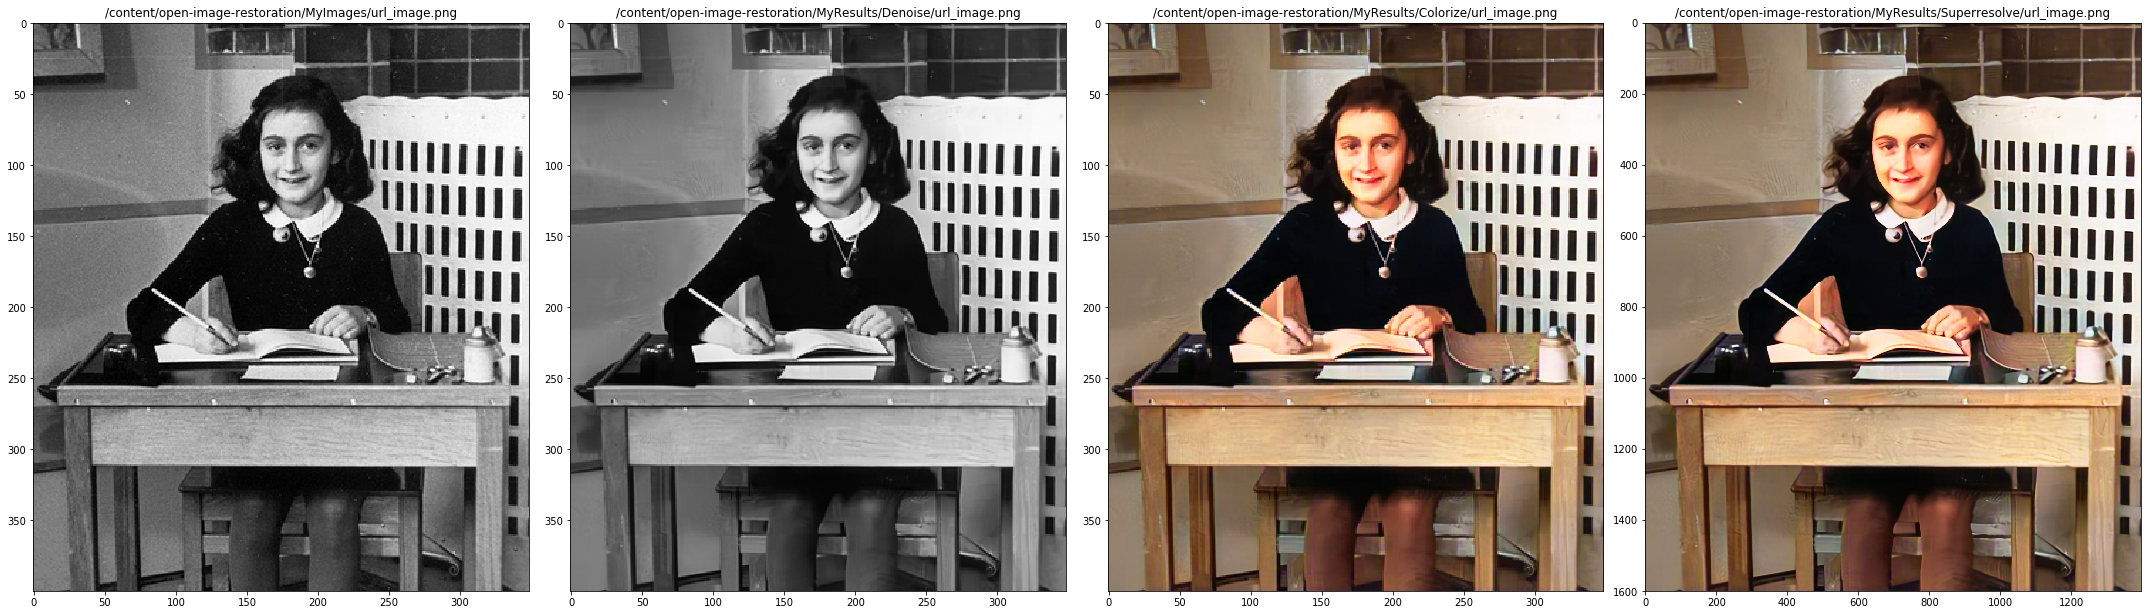

In [9]:
#@title Choose the processing steps to use on your images { display-mode: "form" }

#@markdown The process should take at least a minute so please be patient, mainly due to the loading of the deep-learning models. 

#@markdown Note that at the first execution, the process make take longer as some model files may need to be downloaded.

#@markdown Finally, note that the denoising process is from far the slowest one (however, it can be reduced with smaller image sizes, and by increasing stride and reducing patch_size parameters, but with a cost on quality).



#@markdown ---

#Step_1 = "denoise"  #@param ['denoise', 'colorize', 'super-resolve']
#Step_2 = "colorize"  #@param ['denoise', 'colorize', 'super-resolve']
#Step_3 = "super-resolve"  #@param ['denoise', 'colorize', 'super-resolve']

Denoise = True #@param {type:"boolean"} 
Colorize = True #@param {type:"boolean"}
Superresolve = True #@param {type:"boolean"}


#@markdown ---
#@markdown You can change default algorithm parameters below
#@markdown ---

colorisation_rendering = 15 #@param {type:"slider", min:5, max:40, step:1}
denoising_stride = 12 #@param {type:"slider", min:3, max:20, step:1}
denoising_patch_size = 25 #@param {type:"slider", min:10, max:50, step:1}
superresolution_method = "PSNR"  #@param ['GAN', 'PSNR']

#@markdown If you have bad results for denoising, you should consider to reduce stride and increase patch_size. In the original coda, stride is fixed to 7 and default patch-size is set to 43.

#@markdown If you have bad results for colorization, you should consider to try various numbers for the rendering parameter. Higher rendering generally leads to more stable results, but less colorfull.

#@markdown ---
#@markdown Check the box below to hide most console outputs
#@markdown ---

hide_output = True #@param {type:"boolean"}

input_base = osp.join(base_dir, 'MyImages')
input_dir = input_base
output_base = osp.join(base_dir, 'MyResults')

result_dirs = []
result_dirs.append(input_base)

os.chdir(base_dir)

def initDir(folder):
  
  if osp.exists(folder):    
    shutil.rmtree(folder)
    
  os.makedirs(folder)


input_names = os.listdir(input_base)
ncols = 1 + Denoise + Colorize + Superresolve
col = 0
nfiles = len(input_names)
    
if Denoise:  
  
  print('Starting denoising... It might take a few minutes depending on the number and size of images to process, and the parameters used...')
  with timing('Denoising'):
    #    
      
    output_dir = osp.join(output_base, 'Denoise')  
    initDir(output_dir)
      
    if hide_output: 
      with suppress_stdout():
        !python denoiser.py -i {input_dir} -o {output_dir} -p {denoising_patch_size} -s {denoising_stride}
    else:
      !python denoiser.py -i {input_dir} -o {output_dir} -p {denoising_patch_size} -s {denoising_stride}

    result_dirs.append(output_dir)
    input_dir = output_dir
      
if Colorize:
  
  print('Starting colorisation... It should take a few seconds to load the model, and a few more seconds for each image to colorize...')
  with timing('Colorisation'):   
        
    output_dir = osp.join(output_base, 'Colorize')  
    initDir(output_dir)
    
    if hide_output: 
      with suppress_stdout():      
        !python colorizer.py -i {input_dir} -o {output_dir} -r {colorisation_rendering}
    else:
      !python colorizer.py -i {input_dir} -o {output_dir} -r {colorisation_rendering}
    
    result_dirs.append(output_dir) 
    input_dir = output_dir
      
if Superresolve:
  
  print("Starting super-resolution... It shouldn't be too long now...")
  with timing('Super-resolution'):  
    #with suppress_stdout():      
        
    output_dir = osp.join(output_base, 'Superresolve')  
    initDir(output_dir)
      
    if hide_output: 
      with suppress_stdout():      
        !python superresolution.py -i {input_dir} -o {output_dir} -a {superresolution_method}
    else:
      !python superresolution.py -i {input_dir} -o {output_dir} -a {superresolution_method}
      
    result_dirs.append(output_dir)


dirs = result_dirs

ndir = len(dirs)

imname = '*'
orignames = glob.glob(osp.join(input_base, imname))

cmap = None

print("Rendering images...")

for i in range(0,len(orignames)):
  
  fig, axes = plt.subplots(nrows=1, ncols=ndir)
  fig.set_size_inches((30,30))
  fig.tight_layout()
  
  #original
  orig = orignames[i]

   
  for j in range(0,len(dirs)):
    
    mydir = dirs[j]
  
    #new file
    path, file = os.path.split(orig)
    #print(file)  
    newfile = osp.join(mydir, file)

    img = PIL.Image.open(newfile)
    if IP.is_grayscale(img): 
      cmap = 'gray'
    else:
      cmap = None
    axes[j].imshow(img, cmap)
    #if j == 0:
    axes[j].set_title(newfile)